### House prediction API

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pandasql as ps
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

wd = "data/"
print(os.listdir(wd))

['housing.csv', 'information about housing.csv.txt', 'assignment.txt']


In [3]:
# load dataset
train = pd.read_csv(wd+'housing.csv')

In [4]:
train.head()

,crime_rate,avg_number_of_rooms,distance_to_employment_centers,property_tax_rate,pupil_teacher_ratio,house_value
0,0.02731,6.421,4.9671,242.0,17.8,21.6
1,0.02729,7.185,4.9671,242.0,17.8,34.7
2,0.03237,6.998,6.0622,222.0,18.7,33.4
3,0.06905,7.147,6.0622,222.0,18.7,36.2
4,0.02985,6.430,6.0622,222.0,18.7,28.7


In [5]:
train.describe()

,crime_rate,avg_number_of_rooms,distance_to_employment_centers,property_tax_rate,pupil_teacher_ratio,house_value
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,3.620667,6.284059,3.794459,408.459406,18.461782,22.529901
std,8.608572,0.703195,2.107757,168.629992,2.162520,9.205991
min,0.009060,3.561000,1.129600,187.000000,12.600000,5.000000
25%,0.082210,5.885000,2.100000,279.000000,17.400000,17.000000
50%,0.259150,6.208000,3.199200,330.000000,19.100000,21.200000
75%,3.678220,6.625000,5.211900,666.000000,20.200000,25.000000
max,88.976200,8.780000,12.126500,711.000000,22.000000,50.000000


In [6]:
# check missing data
train_na = (train.isnull().sum() / len(train)) * 100
#train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head(20)

,Missing Ratio
crime_rate,0.0
avg_number_of_rooms,0.0
distance_to_employment_centers,0.0
property_tax_rate,0.0
pupil_teacher_ratio,0.0
house_value,0.0


In [7]:
train.corr()

,crime_rate,avg_number_of_rooms,distance_to_employment_centers,property_tax_rate,pupil_teacher_ratio,house_value
crime_rate,1.000000,-0.218978,-0.379627,0.582568,0.289394,-0.388249
avg_number_of_rooms,-0.218978,1.000000,0.205170,-0.291680,-0.355116,0.695365
distance_to_employment_centers,-0.379627,0.205170,1.000000,-0.534492,-0.232561,0.249896
property_tax_rate,0.582568,-0.291680,-0.534492,1.000000,0.460100,-0.468543
pupil_teacher_ratio,0.289394,-0.355116,-0.232561,0.460100,1.000000,-0.508411
house_value,-0.388249,0.695365,0.249896,-0.468543,-0.508411,1.000000


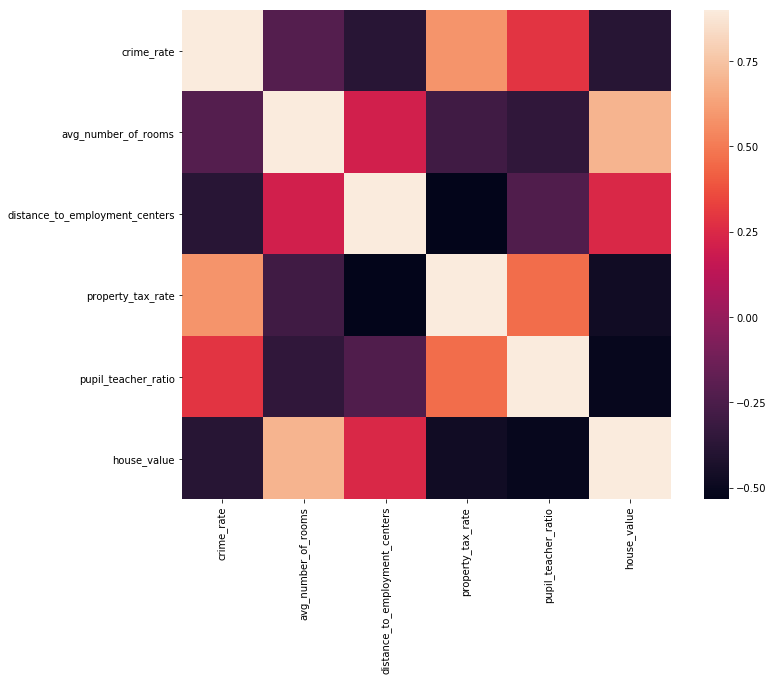

In [8]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [9]:
# chart some of highly correlated features
def draw_housing_data_scatter(feature1, feature2):
    plt.scatter(train[feature1], train[feature2])
    corr = train.corr().ix[feature1, feature2]
    plt.title('{} vs {} (corr={:.2f})'.format(feature1, feature2, corr))
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()

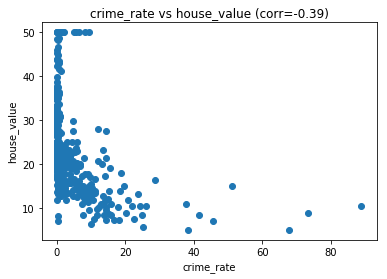

In [10]:
draw_housing_data_scatter(
        'crime_rate',  
        'house_value'
)

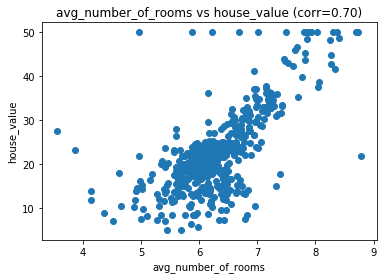

In [11]:
draw_housing_data_scatter(
        'avg_number_of_rooms',  
        'house_value'
)

In [12]:
housing_prices = train.ix[:,['house_value']]
housing_prices.head()

,house_value
0,21.6
1,34.7
2,33.4
3,36.2
4,28.7


In [13]:
housing_features = train.ix[:,0:-1]
housing_features.head()

,crime_rate,avg_number_of_rooms,distance_to_employment_centers,property_tax_rate,pupil_teacher_ratio
0,0.02731,6.421,4.9671,242.0,17.8
1,0.02729,7.185,4.9671,242.0,17.8
2,0.03237,6.998,6.0622,222.0,18.7
3,0.06905,7.147,6.0622,222.0,18.7
4,0.02985,6.430,6.0622,222.0,18.7


In [14]:
from sklearn.model_selection import train_test_split


#Randomly shuffle the sample set. 
#Divide it into training and testing set

def prepare_train_test_data(feature_list, test_size):
    X_train, X_test, y_train, y_test = train_test_split(housing_features[feature_list], 
                                                        housing_prices, 
                                                        test_size=test_size, 
                                                        random_state=1)
    print('{}'.format(feature_list))
    print('test_size={:.1f}%'.format(test_size*100))
    print('X_train.shape={}'.format(X_train.shape))
    print('y_train.shape={}'.format(y_train.shape))
    print('X_test.shape={}'.format(X_test.shape))
    print('y_test.shape={}'.format(y_test.shape))
    
    return X_train, X_test, y_train, y_test

In [15]:
X_train, X_test, y_train, y_test = prepare_train_test_data(housing_features.columns, 0.1)

Index(['crime_rate', 'avg_number_of_rooms', 'distance_to_employment_centers',
       'property_tax_rate', 'pupil_teacher_ratio'],
      dtype='object')
test_size=10.0%
X_train.shape=(454, 5)
y_train.shape=(454, 1)
X_test.shape=(51, 5)
y_test.shape=(51, 1)


In [16]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

print("Coefficient")
print(model.coef_)
print("Intercept")
print(model.intercept_)

Coefficient
[[-0.13005613  7.03437392 -0.18863495 -0.00922052 -0.85931009]]
Intercept
[-0.83998503]


74% accuracy

In [17]:
print(model.score(X_test, y_test))

0.7426127890174461


In [18]:
import pickle
pickle.dump(model, open('house_prediction.pkl', 'wb'))

In [19]:
y_pred = model.predict(X_test)

In [20]:
# Root Mean Squared Error(RMSE)
# RMSE is the standard deviation of the residuals (prediction errors). 
# Residuals are a measure of how far from the regression line data points are, 
# and RMSE is a measure of how spread out these residuals are.

from sklearn import metrics

print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

5.147140240483398


In [21]:
pickle.dump(np.sqrt(metrics.mean_squared_error(y_test,y_pred)), open('stddev.pkl', 'wb'))